In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.optimize import curve_fit

# 連続NDフィルタ

NDL-10C-2

https://www.thorlabs.co.jp/newgrouppage9.cfm?objectgroup_id=1623&pn=NDL-10C-2

$$
    T:透過率 \quad OD:光学濃度 \\
    OD = \log_{10} (\frac{1}{T}) \quad or \quad T = 10^{-OD}
$$


In [2]:
def optical_density(length):
    """
    length: mm
    """
    if length <= 5:
        return 0
    elif length <= 50:
        return (length-5) * 2 / 45
    else:
        return 2

In [3]:
def transmisson(od):
    """
    od: optical density
    """
    return 10 ** (-od)

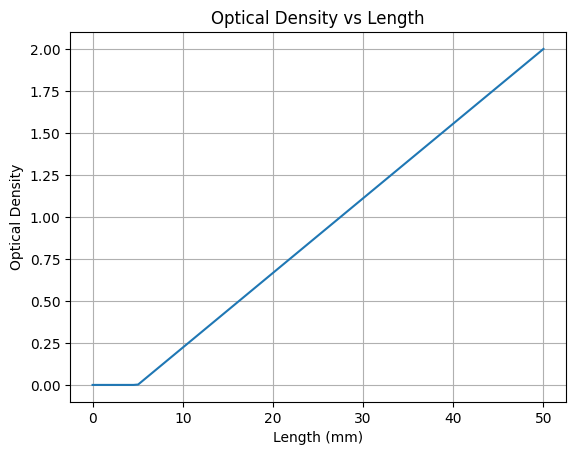

In [4]:
xlist = np.linspace(0, 50, 100)
ylist = [optical_density(x) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Length (mm)")
plt.ylabel("Optical Density")
plt.title("Optical Density vs Length")
plt.grid()
plt.show()

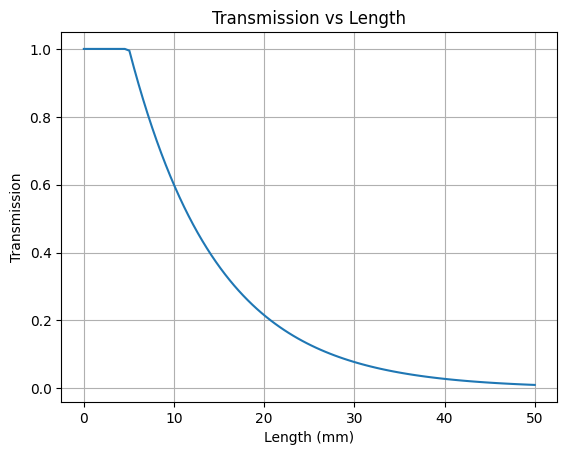

In [5]:
xlist = np.linspace(0, 50, 100)
ylist = [transmisson(optical_density(x)) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Length (mm)")
plt.ylabel("Transmission")
plt.title("Transmission vs Length")
plt.grid()
plt.show()

### ビームスプリッタを考慮したモデル

In [6]:
splitratio = 0.92

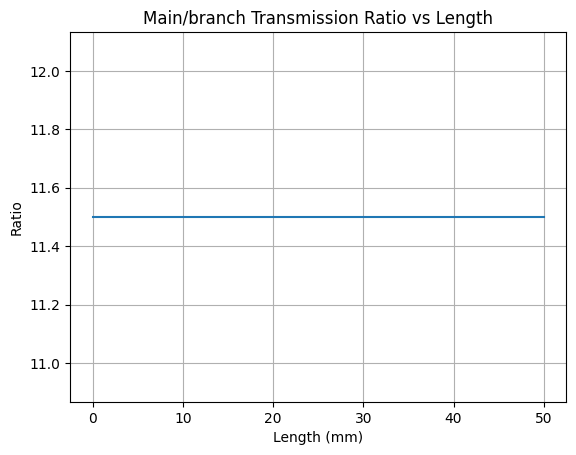

In [7]:
xlist = np.linspace(0, 50, 100)
ylist = [transmisson(optical_density(x)) for x in xlist]
main = [y * splitratio for y in ylist]
branch = [y * (1 - splitratio) for y in ylist]
ratio = [m/b for m, b in zip(main, branch)]
plt.plot(xlist, ratio)
plt.xlabel("Length (mm)")
plt.ylabel("Ratio")
plt.title("Main/branch Transmission Ratio vs Length")
plt.grid()
plt.show()

# パワーメータによる実際の計測データの可視化

In [8]:
lengthlist = [488, 561, 633, 785]

In [9]:
dfdict = {}
for length in lengthlist:
    tempdata =  pl.read_csv(f"../data/{length}.csv", has_header=True)
    for col in tempdata.columns:#convert from W to mW
        if col == "step" or "ratio" in col:
            continue
        tempdata = tempdata.with_columns(tempdata[col] * 1000)
    groupdata = tempdata.group_by("step").agg(
        pl.mean("handy-end").name.suffix("_mean"),
        pl.std("handy-end").name.suffix("_std"),
        pl.mean("handy-mid").name.suffix("_mean"),
        pl.std("handy-mid").name.suffix("_std"),
        pl.mean("set").name.suffix("_mean"),
        pl.std("set").name.suffix("_std"),
    )
    groupdata = groupdata.sort("step")
    groupdata = groupdata.with_columns((groupdata["handy-end_mean"] / groupdata["handy-mid_mean"]).alias("ratio_mean"))
    groupdata = groupdata.with_columns(ratio_std = groupdata["ratio_mean"] * (groupdata["handy-end_std"] / groupdata["handy-end_mean"] + groupdata["handy-mid_std"] / groupdata["handy-mid_mean"]))
    dfdict[length] = groupdata

In [10]:
def plotdata(df, length):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.plot(df["step"], df[f"handy-end_mean"], label="handy-end", color="red")
    ax1.errorbar(df["step"], df[f"handy-end_mean"], yerr=df[f"handy-end_std"], fmt='o', capsize=5, color="red", markerfacecolor='none')

    ax1.plot(df["step"], df[f"handy-mid_mean"], label="handy-mid", color="blue")
    ax1.errorbar(df["step"], df[f"handy-mid_mean"], yerr=df[f"handy-mid_std"], fmt='o', capsize=5, color="blue", markerfacecolor='none')
    
    ax1.plot(df["step"], df[f"set_mean"], label="set", color="green")
    ax1.errorbar(df["step"], df[f"set_mean"], yerr=df[f"set_std"], fmt='o', capsize=5, color="green", markerfacecolor='none')

    ax2 = ax1.twinx()
    ax2.plot(df["step"], df["ratio_mean"], label="ratio", color="black")
    ax2.errorbar(df["step"], df["ratio_mean"], yerr=df["ratio_std"], fmt='o', capsize=5, color="black", markerfacecolor='none')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right')

    ax1.set_ylabel("power[mW]")
    ax2.set_ylabel("Ratio")
    ax1.set_xlabel("Step")

    plt.title(f"Length: {length} mm")

    plt.show()

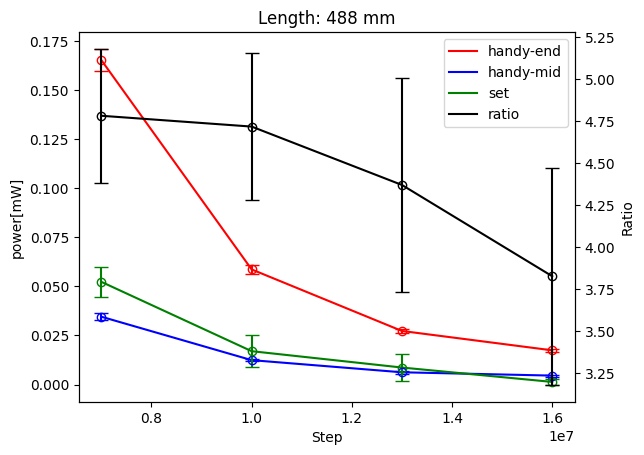

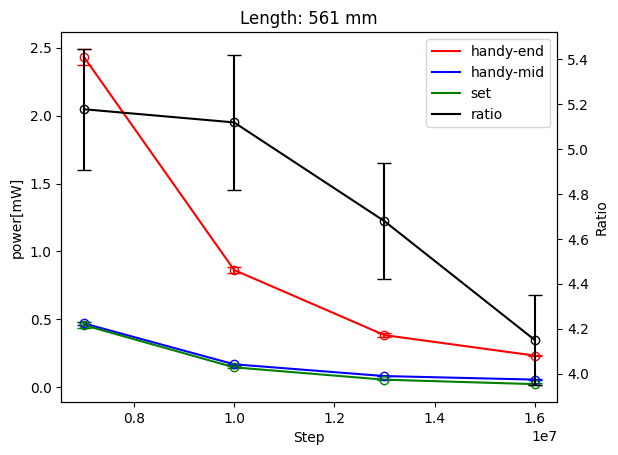

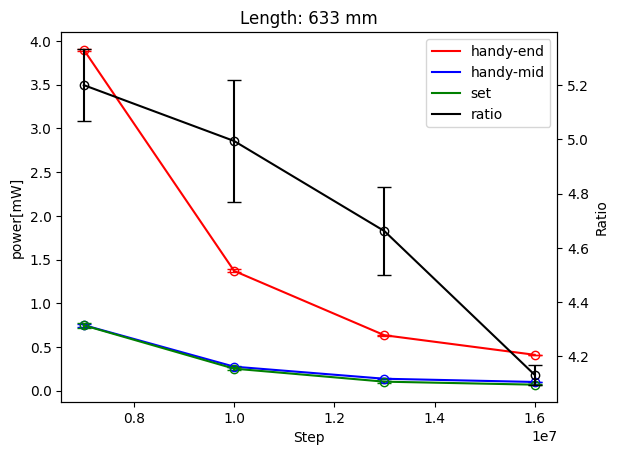

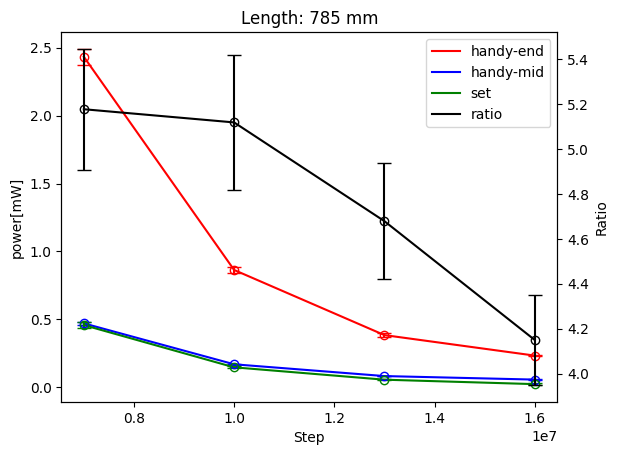

In [11]:
for length in lengthlist:
    plotdata(dfdict[length], length)

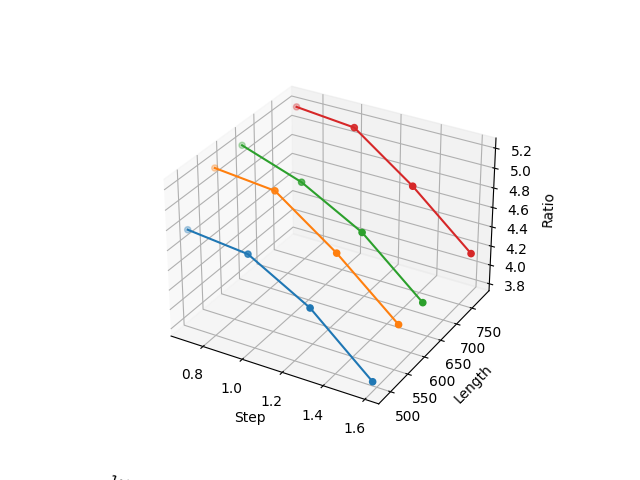

In [12]:
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("Step")
ax.set_ylabel("Length")
ax.set_zlabel("Ratio")
for length in lengthlist:
    ax.plot(dfdict[length]["step"], [length] * len(dfdict[length]), dfdict[length]["ratio_mean"])
    ax.scatter(dfdict[length]["step"], [length] * len(dfdict[length]), dfdict[length]["ratio_mean"])
plt.show()

波長依存性ないかも

In [13]:
plt.close()

# フィッティング

In [24]:
%matplotlib inline

In [25]:
def func(x, a, b, c, d):
    return -1 * a * np.exp(b * (x-c)) + d

[2.92800423e-01 2.10349362e-07 9.10476001e+06 5.38950106e+00]


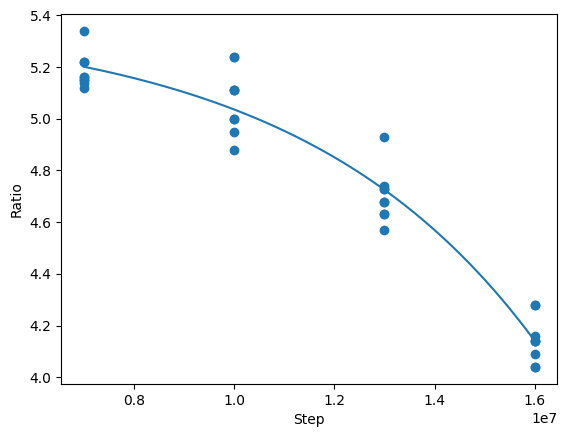

In [26]:
data = None
for idx, length in enumerate(lengthlist):
    if length == 488:#skip 488
        continue

    df = pl.read_csv(f"../data/{length}.csv", has_header=True)

    if idx == 1:
        data = df.select("step", "ratio")
    else:
        data = pl.concat([data, df.select("step", "ratio")])

step = data["step"].to_numpy().astype(np.float64)
ratio = data["ratio"].to_numpy().astype(np.float64)


plt.scatter(step, ratio)
p0 = [0.5, 0.5e-6, 7, 5]
popt, pcov = curve_fit(func, step, ratio, p0=p0)
print(popt)
xlist = np.linspace(7e6, 16e6, 100)
plt.plot(xlist, func(xlist, *popt))
plt.xlabel("Step")
plt.ylabel("Ratio")
plt.show()

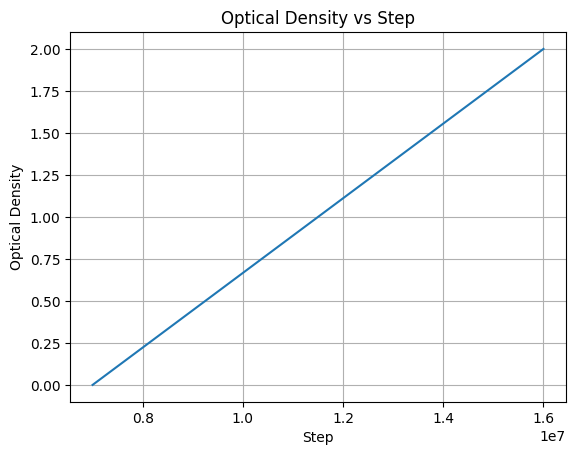

In [27]:
def optical_density_step(step):
    if step <= 1.6e7:
        return (step- 0.7e7) * 2 /0.9e7
    else:
        return 2
xlist = np.linspace(0.7e7, 1.6e7, 100)
ylist = [optical_density_step(x) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Step")
plt.ylabel("Optical Density")
plt.title("Optical Density vs Step")
plt.grid()
plt.show()

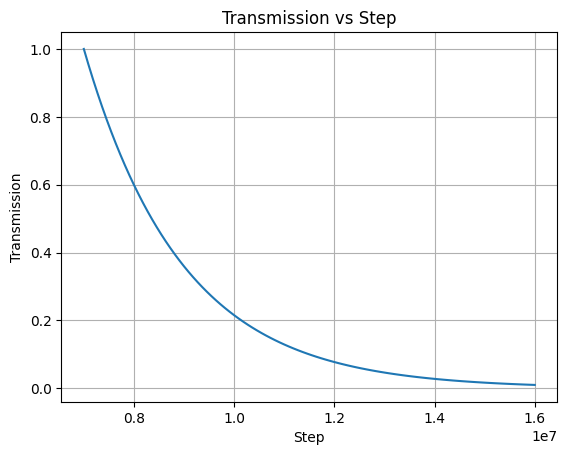

In [28]:
xlist = np.linspace(0.7e7, 1.6e7, 100)
ylist = [transmisson(optical_density_step(x)) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Step")
plt.ylabel("Transmission")
plt.title("Transmission vs Step")
plt.grid()
plt.show()

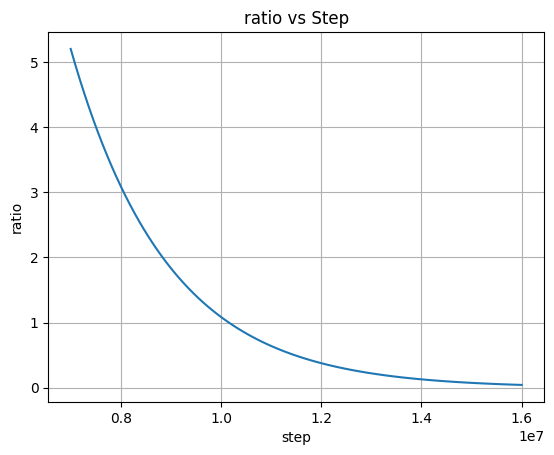

In [29]:
xlist = np.linspace(0.7e7, 1.6e7, 100)
ylist = [transmisson(optical_density_step(x)) * func(x, *popt) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("step")
plt.ylabel("ratio")
plt.title("ratio vs Step")
plt.grid()
plt.show()

In [30]:
def inverse_func(y, a, b, c, d):
    return -1 * a * np.log((y + b) / c) + d

In [31]:
opt, cov = curve_fit(inverse_func, ylist, xlist, p0=[1e7, 1,1,2e7], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
print(opt)

[1.90691015e+06 5.73903423e-03 3.75046314e-02 1.64199690e+07]


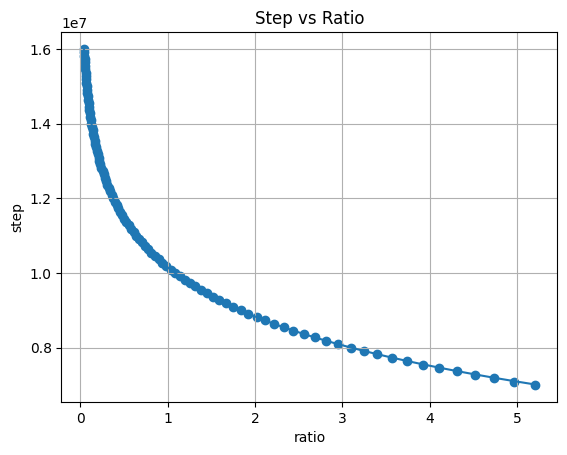

In [32]:
plt.scatter(ylist, xlist)
plt.plot(ylist, inverse_func(ylist, *opt))
plt.xlabel("ratio")
plt.ylabel("step")
plt.title("Step vs Ratio")
plt.grid()
plt.show()